In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import re
import warnings
from sklearn import linear_model

In [89]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

warnings.filterwarnings('ignore')
#sns.set(style="whitegrid")

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df_full = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [90]:
df = df_full[['id', 'lotarea', 'lotconfig', 'neighborhood', 'overallqual', 'yearremodadd', 'exterior1st',
             'exterior2nd', 'masvnrtype', 'bsmtfintype1', 'bsmtfinsf1', 'totalbsmtsf', 'centralair', 'grlivarea',
             'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenqual',
             'totrmsabvgrd', 'fireplaces', 'garagetype', 'garagecars', 'wooddecksf', 'openporchsf', 
             'enclosedporch', 'screenporch', 'yrsold', 'saleprice']]

In [91]:
#combine the 4 'bath' features into one
df['bath'] = df['bsmtfullbath']+df['bsmthalfbath']+df['fullbath']+df['halfbath']

In [75]:
df = df.drop(['bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath'], axis=1)

In [76]:
#replace blanks in rows with appropriate values
for i, j in df.iterrows():
    if df['masvnrtype'][i] == '':
        df['masvnrtype'][i] = 'None'
    if df['bsmtfintype1'][i] == '':
        df['bsmtfintype1'][i] = 'Unf'
    if df['garagetype'][i] == '':
        df['garagetype'][i] = 'None'

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 27 columns):
id               1460 non-null int64
lotarea          1460 non-null int64
lotconfig        1460 non-null object
neighborhood     1460 non-null object
overallqual      1460 non-null int64
yearremodadd     1460 non-null int64
exterior1st      1460 non-null object
exterior2nd      1460 non-null object
masvnrtype       1452 non-null object
bsmtfintype1     1423 non-null object
bsmtfinsf1       1460 non-null int64
totalbsmtsf      1460 non-null int64
centralair       1460 non-null object
grlivarea        1460 non-null int64
bedroomabvgr     1460 non-null int64
kitchenqual      1460 non-null object
totrmsabvgrd     1460 non-null int64
fireplaces       1460 non-null int64
garagetype       1379 non-null object
garagecars       1460 non-null int64
wooddecksf       1460 non-null int64
openporchsf      1460 non-null int64
enclosedporch    1460 non-null int64
screenporch      1460 non-null in

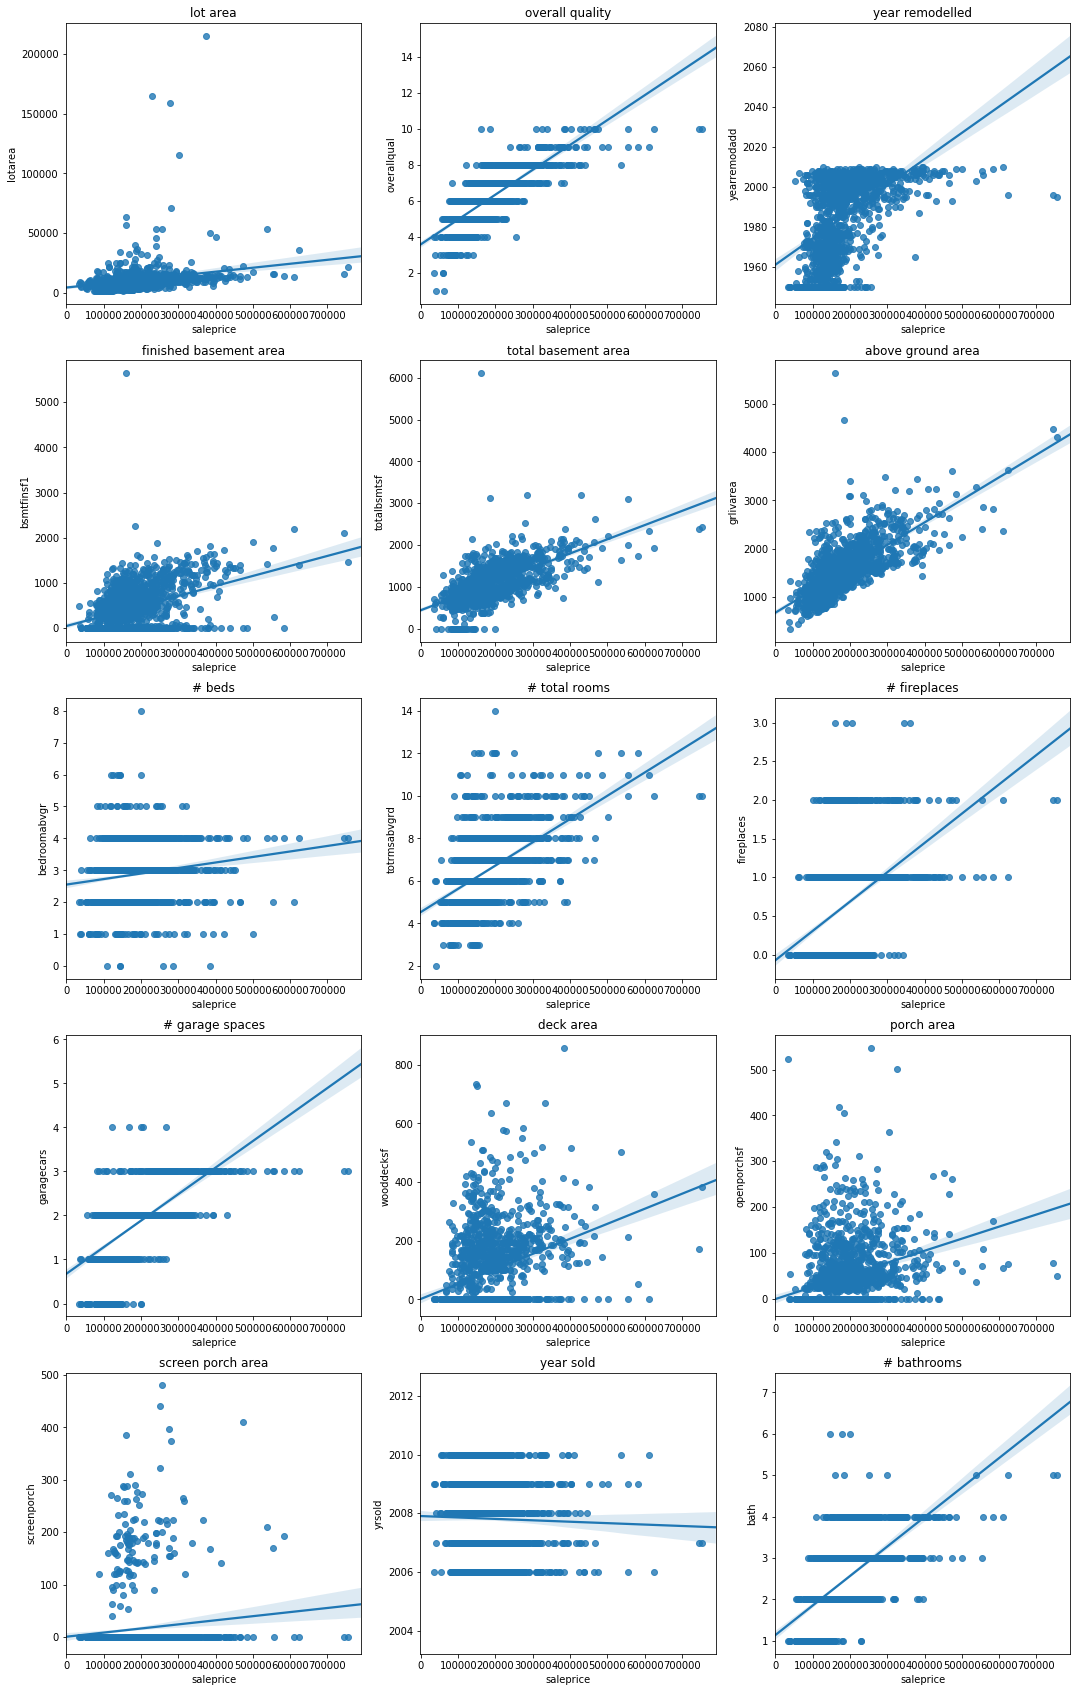

In [78]:
#look at relationship of numeric variables and sales price
plt.figure(figsize=(18,30))

plt.subplot(5,3,1)
sns.regplot(x="saleprice", y="lotarea", data=df, fit_reg=True)
plt.title('lot area')

plt.subplot(5,3,2)
sns.regplot(x="saleprice", y="overallqual", data=df, fit_reg=True)
plt.title('overall quality')

plt.subplot(5,3,3)
sns.regplot(x="saleprice", y="yearremodadd", data=df, fit_reg=True)
plt.title('year remodelled')

plt.subplot(5,3,4)
sns.regplot(x="saleprice", y="bsmtfinsf1", data=df, fit_reg=True)
plt.title('finished basement area')

plt.subplot(5,3,5)
sns.regplot(x="saleprice", y="totalbsmtsf", data=df, fit_reg=True)
plt.title('total basement area')

plt.subplot(5,3,6)
sns.regplot(x="saleprice", y="grlivarea", data=df, fit_reg=True)
plt.title('above ground area')

plt.subplot(5,3,7)
sns.regplot(x="saleprice", y="bedroomabvgr", data=df, fit_reg=True)
plt.title('# beds')

plt.subplot(5,3,8)
sns.regplot(x="saleprice", y="totrmsabvgrd", data=df, fit_reg=True)
plt.title('# total rooms')

plt.subplot(5,3,9)
sns.regplot(x="saleprice", y="fireplaces", data=df, fit_reg=True)
plt.title('# fireplaces')

plt.subplot(5,3,10)
sns.regplot(x="saleprice", y="garagecars", data=df, fit_reg=True)
plt.title('# garage spaces')

plt.subplot(5,3,11)
sns.regplot(x="saleprice", y="wooddecksf", data=df, fit_reg=True)
plt.title('deck area')

plt.subplot(5,3,12)
sns.regplot(x="saleprice", y="openporchsf", data=df, fit_reg=True)
plt.title('porch area')

plt.subplot(5,3,13)
sns.regplot(x="saleprice", y="screenporch", data=df, fit_reg=True)
plt.title('screen porch area')

plt.subplot(5,3,14)
sns.regplot(x="saleprice", y="yrsold", data=df, fit_reg=True)
plt.title('year sold')

plt.subplot(5,3,15)
sns.regplot(x="saleprice", y="bath", data=df, fit_reg=True)
plt.title('# bathrooms')
plt.show()


In [79]:
#based on graphs, drop 'yrsold', 'bedroomabvgr', 'screenporch', 'lotarea'
#transform to remove outliers and see if the variable can be useful: 'wooddecksf', 'openporchsf'
#'yearremodadd'

In [80]:
df = df.drop(['yrsold', 'bedroomabvgr', 'screenporch', 'lotarea'], axis=1)

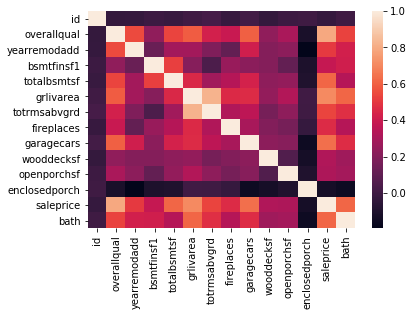

In [81]:
sns.heatmap(df.corr())

#from this we see that 'grlivarea', 'bedroomabvgr' and 'totrmsabvgrd' are all highly correlated, so we'll 
#drop 'totrmsabvgrd' and 'bedroomabvgr' and keep just 'grlivarea'
#also drop 'enclosedporch', which doesn't seem to correlate to price at all

In [82]:
df = df.drop(['enclosedporch', 'totrmsabvgrd'], axis=1)

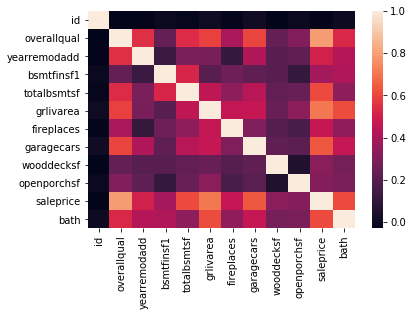

In [84]:
sns.heatmap(df.corr())

In [85]:
#pd.get_dummies(df.lotconfig, drop_first=True)
# append dummies to YouTube dataframe
df1 = pd.concat([df, pd.get_dummies(df['lotconfig'])], axis=1)
df2 = pd.concat([df, pd.get_dummies(df['neighborhood'])], axis=1)
df3 = pd.concat([df, pd.get_dummies(df['masvnrtype'])], axis=1)
df4 = pd.concat([df, pd.get_dummies(df['bsmtfintype1'])], axis=1)
df5 = pd.concat([df, pd.get_dummies(df['centralair'])], axis=1)
df6 = pd.concat([df, pd.get_dummies(df['kitchenqual'])], axis=1)
df7 = pd.concat([df, pd.get_dummies(df['garagetype'])], axis=1)

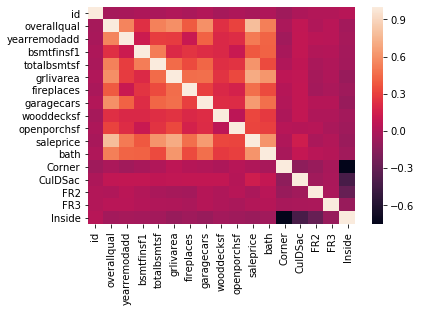

In [86]:
sns.heatmap(df1.corr())
#keep 'CulDSac'

In [15]:
df1 = df1[['id', 'CulDSac']]

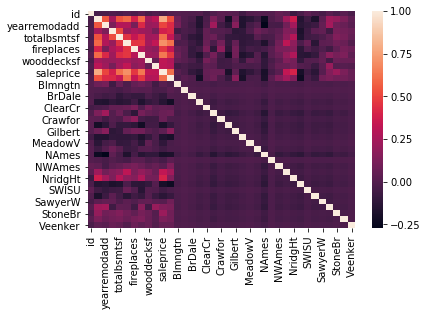

In [87]:
sns.heatmap(df2.corr())
#drop SWISU, SawyerW, Veenker

In [17]:
df2 = df2.drop(['SWISU', 'SawyerW', 'Veenker'], axis=1)

In [59]:
df1 = pd.merge(df1, df2, how='inner')

In [19]:
df3.corr()
#drop HdBoard, ImStucc, Plywood, Other, Stone[1], Stucco, Wd Shng, None, BrkCmm

,id,overallqual,yearremodadd,bsmtfinsf1,totalbsmtsf,grlivarea,fireplaces,garagecars,wooddecksf,openporchsf,saleprice,bath,BrkCmn,BrkFace,None,Stone
id,1.000000,-0.028365,-0.021998,-0.005024,-0.015415,0.008273,-0.019772,0.016570,-0.029643,-0.000477,-0.021917,0.003105,-0.040379,-0.036425,0.024897,0.024760
overallqual,-0.028365,1.000000,0.550684,0.239666,0.537808,0.593007,0.396765,0.600671,0.238923,0.308819,0.790982,0.529906,-0.061362,0.224727,-0.397955,0.331584
yearremodadd,-0.021998,0.550684,1.000000,0.128451,0.291066,0.287389,0.112581,0.420622,0.205726,0.226298,0.507101,0.426079,-0.039818,0.096518,-0.240784,0.260178
bsmtfinsf1,-0.005024,0.239666,0.128451,1.000000,0.522396,0.208171,0.260011,0.224054,0.204306,0.111761,0.386420,0.419852,-0.007398,0.129103,-0.235217,0.188412
totalbsmtsf,-0.015415,0.537808,0.291066,0.522396,1.000000,0.454868,0.339519,0.434585,0.232019,0.247264,0.613581,0.339473,0.004345,0.170289,-0.340757,0.300793
grlivarea,0.008273,0.593007,0.287389,0.208171,0.454868,1.000000,0.461679,0.467247,0.247433,0.330224,0.708624,0.617494,-0.006930,0.163322,-0.246464,0.155787
fireplaces,-0.019772,0.396765,0.112581,0.260011,0.339519,0.461679,1.000000,0.300789,0.200019,0.169405,0.466929,0.341565,0.019022,0.132088,-0.204657,0.129780
garagecars,0.016570,0.600671,0.420622,0.224054,0.434585,0.467247,0.300789,1.000000,0.226342,0.213569,0.640409,0.468671,-0.013700,0.222338,-0.374556,0.284658
wooddecksf,-0.029643,0.238923,0.205726,0.204306,0.232019,0.247433,0.200019,0.226342,1.000000,0.058661,0.324413,0.279980,-0.008656,0.106905,-0.140296,0.077735
openporchsf,-0.000477,0.308819,0.226298,0.111761,0.247264,0.330224,0.169405,0.213569,0.058661,1.000000,0.315856,0.295422,0.004830,0.039857,-0.117854,0.123900


In [20]:
df3 = df3.drop(['BrkCmn'], axis=1)

In [60]:
df1 = pd.merge(df1, df3, how='inner')

In [22]:
df4.corr()

,id,overallqual,yearremodadd,bsmtfinsf1,totalbsmtsf,grlivarea,fireplaces,garagecars,wooddecksf,openporchsf,saleprice,bath,ALQ,BLQ,GLQ,LwQ,Rec,Unf
id,1.000000,-0.028365,-0.021998,-0.005024,-0.015415,0.008273,-0.019772,0.016570,-0.029643,-0.000477,-0.021917,0.003105,-0.016572,0.029997,-0.014934,-0.028664,0.000568,0.022917
overallqual,-0.028365,1.000000,0.550684,0.239666,0.537808,0.593007,0.396765,0.600671,0.238923,0.308819,0.790982,0.529906,-0.167359,-0.181707,0.433448,-0.093390,-0.170811,0.047055
yearremodadd,-0.021998,0.550684,1.000000,0.128451,0.291066,0.287389,0.112581,0.420622,0.205726,0.226298,0.507101,0.426079,-0.088081,-0.184964,0.401679,-0.116811,-0.238877,0.047523
bsmtfinsf1,-0.005024,0.239666,0.128451,1.000000,0.522396,0.208171,0.260011,0.224054,0.204306,0.111761,0.386420,0.419852,0.162801,0.068529,0.497436,-0.032485,0.050661,-0.628690
totalbsmtsf,-0.015415,0.537808,0.291066,0.522396,1.000000,0.454868,0.339519,0.434585,0.232019,0.247264,0.613581,0.339473,-0.013082,-0.041752,0.317396,-0.016780,-0.030998,-0.115146
grlivarea,0.008273,0.593007,0.287389,0.208171,0.454868,1.000000,0.461679,0.467247,0.247433,0.330224,0.708624,0.617494,-0.133668,-0.117177,0.193521,0.001835,-0.061807,0.052649
fireplaces,-0.019772,0.396765,0.112581,0.260011,0.339519,0.461679,1.000000,0.300789,0.200019,0.169405,0.466929,0.341565,0.018233,0.022093,0.114646,-0.016295,-0.031510,-0.085328
garagecars,0.016570,0.600671,0.420622,0.224054,0.434585,0.467247,0.300789,1.000000,0.226342,0.213569,0.640409,0.468671,-0.068600,-0.150471,0.321159,-0.090981,-0.130725,-0.011793
wooddecksf,-0.029643,0.238923,0.205726,0.204306,0.232019,0.247433,0.200019,0.226342,1.000000,0.058661,0.324413,0.279980,0.034171,-0.019927,0.172313,-0.043465,-0.108316,-0.064042
openporchsf,-0.000477,0.308819,0.226298,0.111761,0.247264,0.330224,0.169405,0.213569,0.058661,1.000000,0.315856,0.295422,-0.056607,-0.049432,0.152865,-0.041716,-0.061017,0.010846


In [23]:
df4 = df4[['id', 'GLQ']]

In [61]:
df1 = pd.merge(df1, df4, how='inner')

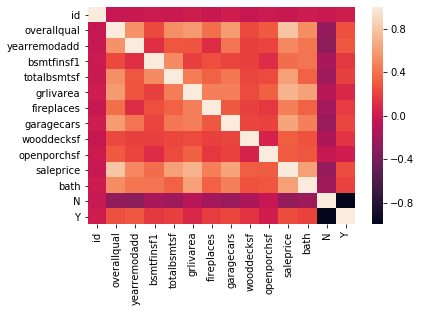

In [25]:
sns.heatmap(df5.corr())

In [26]:
df5 = df5[['id', 'Y']]

In [62]:
df1 = pd.merge(df1, df5, how='inner')

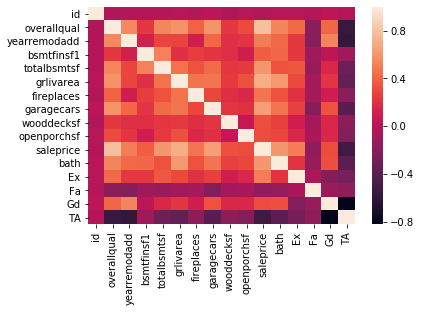

In [28]:
sns.heatmap(df6.corr())

In [29]:
df6 = df6[['id', 'Gd', 'Ex']]

In [63]:
df1 = pd.merge(df1, df6, how='inner')

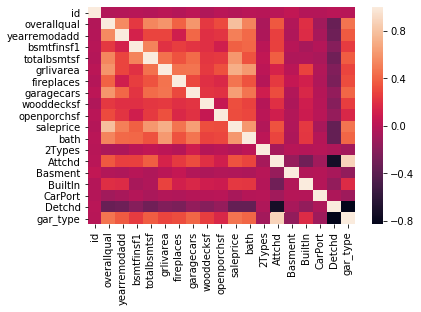

In [31]:
df7['gar_type'] = df7['Attchd']+df7['BuiltIn']
sns.heatmap(df7.corr())

In [32]:
df7 = df7[['id', 'gar_type']]

In [64]:
df1 = pd.merge(df1, df7, how='inner')

In [65]:
df = pd.merge(df, df1, how='inner')

In [66]:
df = df.drop(['lotconfig', 'neighborhood', 'garagetype', 'exterior1st', 'exterior2nd', 'masvnrtype',
              'bsmtfintype1', 'kitchenqual', 'centralair'], axis=1)

In [67]:
data = df.drop(['id', 'saleprice'], axis=1)

In [47]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = data

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 1.16765267e+04  2.16481186e+02  9.29689794e+00  1.42817726e+01
  3.73001103e+01  6.09808977e+03  1.20039994e+04  2.93128153e+01
  1.56028945e+01  4.49977131e+03  1.58189737e+04 -6.69766955e+03
 -2.88395918e+04 -1.89969577e+04  5.69686212e+03  1.33456776e+04
  6.74107541e+03  2.67709609e+04 -9.25826341e+03  2.39175436e+02
 -5.41479136e+03 -2.01916720e+04 -6.04137629e+03 -2.90922378e+02
 -1.91878341e+04 -6.14098218e+03  5.90112892e+04  4.39488880e+04
 -1.32630390e+04 -2.84243595e+03  1.51269716e+04  4.86159039e+04
  1.73727846e+04  7.98581580e+03  1.07922644e+04  1.29751173e+04
  3.49918116e+03  6.72590449e+03  2.15822998e+03  4.64026778e+04
  5.03502180e+03]

Intercept: 
 -465829.7002568708


In [69]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     181.7
Date:                Mon, 08 Jul 2019   Prob (F-statistic):               0.00
Time:                        20:27:55   Log-Likelihood:                -17206.
No. Observations:                1460   AIC:                         3.450e+04
Df Residuals:                    1418   BIC:                         3.472e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -4.658e+05    1.2e+05     -3.879      0.000   -7.01e+05    -2.3e+05
overallqual   1.168e+04   1167.949      9.997      0.000    9385.434     1.4e+04
yearremodadd   216.4812     61.277      3.533      0.000      96.278     336.684
bsmtfinsf1       9.2969      2.807      3.312      0.001       3.790      14.804
totalbsmtsf     14.2818      2.893      4.936      0.000       8.606      19.957
grlivarea       37.3001      2.719     13.720      0.000      31.967      42.633
fireplaces    6098.0898   1664.835      3.663      0.000    2832.286    9363.894
garagecars      1.2e+04   1573.895      7.627      0.000    8916.586    1.51e+04
wooddecksf      29.3128      7.384      3.970      0.000      14.827      43.798
openporchsf     15.6029     14.248      1.095      0.274     -12.346      43.552
bath          4499.7713   1537.512      2.927      0.003    1483.729    7515.813
CulDSac       1.582e+04   3564.704      4.438      0.000    8826.314    2.28e+04
Blmngtn      -6697.6696   8937.668     -0.749      0.454   -2.42e+04    1.08e+04
Blueste      -2.884e+04   2.32e+04     -1.244      0.214   -7.43e+04    1.66e+04
BrDale         -1.9e+04   9177.852     -2.070      0.039    -3.7e+04    -993.332
BrkSide       5696.8621   5705.020      0.999      0.318   -5494.324    1.69e+04
ClearCr       1.335e+04   7067.862      1.888      0.059    -518.912    2.72e+04
CollgCr       6741.0754   4441.859      1.518      0.129   -1972.246    1.55e+04
Crawfor       2.677e+04   5777.157      4.634      0.000    1.54e+04    3.81e+04
Edwards      -9258.2634   4845.164     -1.911      0.056   -1.88e+04     246.197
Gilbert        239.1754   5175.465      0.046      0.963   -9913.215    1.04e+04
IDOTRR       -5414.7914   6642.008     -0.815      0.415   -1.84e+04    7614.427
MeadowV      -2.019e+04   8760.762     -2.305      0.021   -3.74e+04   -3006.226
Mitchel      -6041.3763   5857.204     -1.031      0.303   -1.75e+04    5448.340
NAmes         -290.9224   4215.865     -0.069      0.945   -8560.925    7979.081
NPkVill      -1.919e+04   1.15e+04     -1.674      0.094   -4.17e+04    3294.741
NWAmes       -6140.9822   5259.212     -1.168      0.243   -1.65e+04    4175.690
NoRidge       5.901e+04   6480.750      9.106      0.000    4.63e+04    7.17e+04
NridgHt       4.395e+04   5798.102      7.580      0.000    3.26e+04    5.53e+04
OldTown      -1.326e+04   4794.570     -2.766      0.006   -2.27e+04   -3857.827
Sawyer       -2842.4360   5218.440     -0.545      0.586   -1.31e+04    7394.257
Somerst       1.513e+04   5233.800      2.890      0.004    4860.148    2.54e+04
StoneBr       4.862e+04   7606.786      6.391      0.000    3.37e+04    6.35e+04
Timber        1.737e+04   6361.641      2.731      0.006    4893.546    2.99e+04
BrkFace       7985.8158   7029.264      1.136      0.256   -5803.057    2.18e+04
None 